In [8]:
import cv2 as cv
import numpy as np

In [9]:
def showimage(image,label = "image"):
    cv.imshow(label,image)
    cv.waitKey()
    cv.destroyAllWindows()

In [10]:
def histogram_eq(image:np.ndarray,bin = 256)->np.ndarray:
    
    
    intensity, a,b = cv.split(cv.cvtColor(image,cv.COLOR_BGR2LAB))
    ## Find the histogram of the intensities of each pixels within a bin size of 256
    hist, _ = np.histogram(intensity, bins=bin)
    cumulative_sum = hist.cumsum()
    
    ## Gets the lowest nonzero element
    sort = cumulative_sum.argsort()
    cummin = cumulative_sum[sort[0]] if cumulative_sum[sort[0]]!=0 else cumulative_sum[sort[1]]
    # cummin = cumulative_sum[cumulative_sum.nonzero()][cumulative_sum[cumulative_sum.nonzero()].argsort()[0]]
    
    ## Perform the equation found on wikipedia
    equ_intensities = np.round(((cumulative_sum[intensity.flatten()]-cummin)/((image.shape[0]*image.shape[1])-cummin)*255))
    ## Reshape back into the shape of the image
    new_intensities = equ_intensities.reshape((image.shape[0],image.shape[1])).astype(np.uint8)
    
    ## Merge the intensities back with the A,B values
    new_image = cv.merge([new_intensities,a,b])
    ## Convert back to BGR Space
    new_image = cv.cvtColor(new_image,cv.COLOR_LAB2BGR)
    
    return new_image

In [11]:
def bilinear_interpolate(im, x, y):
    x = np.asarray(x)
    y = np.asarray(y)

    x0 = np.floor(x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y).astype(int)
    y1 = y0 + 1

    x0 = np.clip(x0, 0, im.shape[1]-1);
    x1 = np.clip(x1, 0, im.shape[1]-1);
    y0 = np.clip(y0, 0, im.shape[0]-1);
    y1 = np.clip(y1, 0, im.shape[0]-1);

    Ia = im[ y0, x0 ]
    Ib = im[ y1, x0 ]
    Ic = im[ y0, x1 ]
    Id = im[ y1, x1 ]

    wa = (x1-x) * (y1-y)
    wb = (x1-x) * (y-y0)
    wc = (x-x0) * (y1-y)
    wd = (x-x0) * (y-y0)

    return (Ia.T*wa).T + (Ib.T*wb).T + (Ic.T*wc).T + (Id.T*wd).T

In [12]:
def adaptive_eq(image:np.ndarray, tile_size = 8,bin = 256):
    row_tiles = np.array_split(image,image.shape[0]/tile_size,axis=0)
    eq_image = []
    for row_tile in row_tiles:
        tiles = np.array_split(row_tile, row_tile.shape[1]/tile_size,axis=1)
        row_image = histogram_eq(tiles[0])
        for tile in tiles[1:]:
            eq_tile = histogram_eq(tile)
            row_image = np.hstack((row_image,eq_tile))
        eq_image.append(row_image)
    new_image = np.vstack(eq_image)
    boundries_x, boundries_y = list(range(0,new_image.shape[0]-1,tile_size)),list(range(0,new_image.shape[1]-1,tile_size))
    for x in boundries_x:
            new_image[x,boundries_y] = bilinear_interpolate(new_image,x,boundries_y)
    # intensities = bilinear_interpolate(new_image,boundries_x,boundries_y)
    # new_image[boundries_x,boundries_y] = intensities
    return new_image

In [13]:
size = (int(1224),int(370))
result_hist = cv.VideoWriter('Question_1_histogram.avi', cv.VideoWriter_fourcc(*'MJPG'),10, size) 
result_adapt = cv.VideoWriter('Question_1_adaptive_histogram.avi', cv.VideoWriter_fourcc(*'MJPG'),10, size) 

In [14]:
import glob
output_frame = np.zeros((size[1]*3,size[0],3),dtype=np.uint8)
images = [cv.imread(file) for file in glob.glob('./Data/*.png')]
for image in images:
    output_hist = histogram_eq(image)
    output_adapt = adaptive_eq(image,150)
    output_frame[0:size[1],0:size[0]] = image
    output_frame[size[1]:size[1]*2,:size[0]] = output_hist
    output_frame[size[1]*2:,:size[0]] = output_adapt
    cv.imshow("output",output_frame)
    if cv.waitKey(0) & 0xFF == ord('s'):
            cv.destroyAllWindows()
            break
    # result_hist.write(output_hist)
    # result_adapt.write(output_adapt)
cv.waitKey(1)
cv.destroyAllWindows()
    

In [9]:
def calculate_ssd(img1, img2):
    """Computing the sum of squared differences (SSD) between two images."""
    if img1.shape != img2.shape:
        print("Images don't have the same shape.")
        return
    return np.sum((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32))**2)

In [16]:
import matplotlib.pyplot as plt

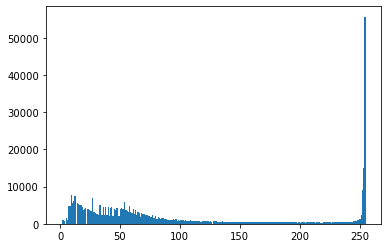

In [39]:
intensity,_,_ = cv.split(cv.cvtColor(image,cv.COLOR_BGR2LAB))
_ = plt.hist(intensity.flatten(),bins=256)
plt.title("Histogram of the Original Image")
plt.show()

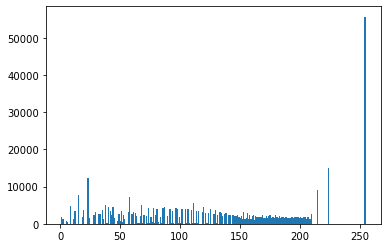

In [41]:
intensity,_,_ = cv.split(cv.cvtColor(output_hist,cv.COLOR_BGR2LAB))
_ = plt.hist(intensity.flatten(),bins=256)
plt.title("Histogram of the Equalized Image")
plt.show()

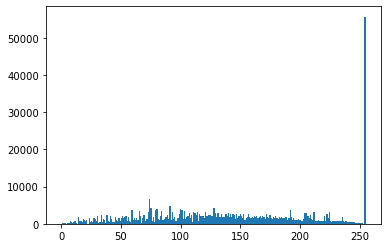

In [42]:
intensity,_,_ = cv.split(cv.cvtColor(output_adapt,cv.COLOR_BGR2LAB))
_ = plt.hist(intensity.flatten(),bins=256)
plt.title("Histogram of the Adaptively equalized Image")
plt.show()